In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from correct_2d_psf import get_fwd_matrices, correct_spice_raster
from util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import astropy.units as u
from astropy.wcs import WCS
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D

from copy import deepcopy

In [2]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000.fits")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


In [3]:
spice_raster.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [4]:
spice_NeVIII_770_window = spice_raster["Ne VIII 770 - Peak"]

In [5]:
spice_NeVIII_770_window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'WAVE' 'TIME' 
CRVAL : 0.29494045034444444 0.12210741052555556 7.70123302e-08 5783.875 
CRPIX : 96.5 416.5 25.5 1.0 
PC1_1 PC1_2 PC1_3 PC1_4  : 0.996644433832 -0.0224685795869 0.0 0.0 
PC2_1 PC2_2 PC2_3 PC2_4  : 0.298188520767 0.996644433832 0.0 0.0 
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0 
PC4_1 PC4_2 PC4_3 PC4_4  : -60.25 0.0 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 9.751700000000001e-12 1.0 
NAXIS : 192  832  50  1

In [6]:
spice_NeVIII_770_window.data.shape

(1, 50, 832, 192)

In [7]:
NeVIII_770_window_rebin = spice_NeVIII_770_window.rebin((1,50,1,1))[0,0,:,:]

In [8]:
NeVIII_770_window_int_map = sunpy.map.Map(NeVIII_770_window_rebin.data, NeVIII_770_window_rebin.meta)

In [9]:
NeVIII_770_window_int_map.plot_settings['cmap'] = 'viridis'
NeVIII_770_window_int_map.plot_settings['aspect'] = NeVIII_770_window_int_map.scale.axis2/NeVIII_770_window_int_map.scale.axis1
NeVIII_770_window_int_map.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))

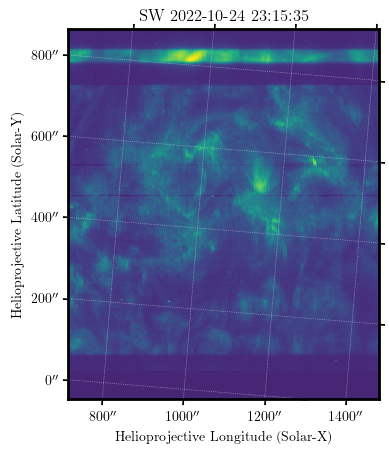

In [10]:
NeVIII_770_window_int_map.plot()

In [11]:
spice_dat = deepcopy(spice_NeVIII_770_window.data[0])
specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]

/tmp/ipykernel_62501/1531182670.py:2: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
/tmp/ipykernel_62501/1531182670.py:4: RuntimeWarning: All-NaN slice encountered
  spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]


In [12]:
spice_dat.shape

(50, 832, 192)

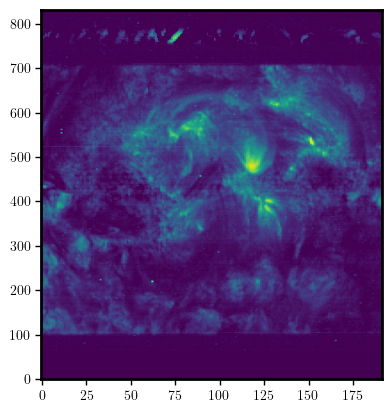

In [51]:
plt.imshow(np.nansum(spice_dat, axis=0)[:,:],origin="lower",norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.1)),
           aspect=1/4)

In [14]:
spice_hdr = spice_NeVIII_770_window.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.5

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -15*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([2, 0.95])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([10.0, 2.5]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.2



In [15]:
spice_hdr["NBIN1"], spice_hdr["NBIN2"], spice_hdr["NBIN3"]

(1, 1, 1)

In [16]:
rebin_facs = [1,4,1]

In [48]:
spice_dat.shape

(50, 832, 192)

In [17]:
spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spicedat_bindown.shape

(50, 145, 192)

In [55]:
NeVIII_770_window_int_map_crop = NeVIII_770_window_int_map.submap([0,120]*u.pix,top_right=[192,699]*u.pix) 

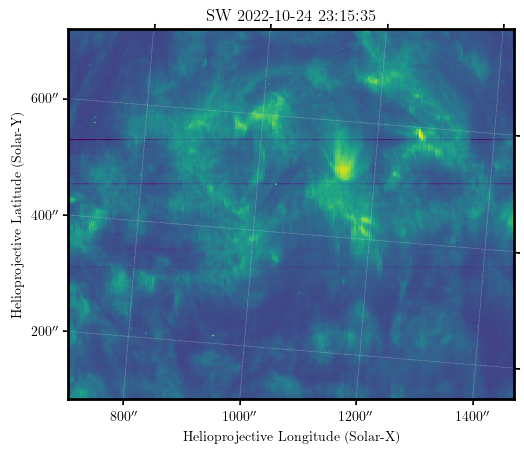

In [56]:
NeVIII_770_window_int_map_crop.plot()

In [72]:
NeVIII_deconv_data_rebin_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.2950902412050266 0.12028355121184009 
CRPIX : 96.5 416.5 
PC1_1 PC1_2  : 0.996644433832 -0.0898743183476 
PC2_1 PC2_2  : 0.07454713019175 0.996644433832 
CDELT : 0.0011111111111111111 0.0012200000000000002 
NAXIS : 192  832

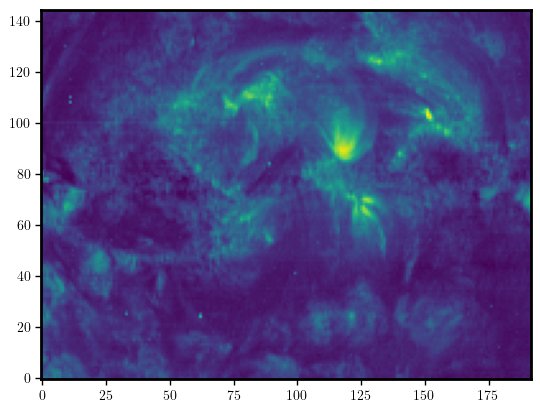

In [18]:
plt.imshow(np.nansum(spicedat_bindown, axis=0)[:,:],origin="lower",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
              aspect=1)

/tmp/ipykernel_62501/3092382005.py:1: RuntimeWarning: invalid value encountered in power
  plt.imshow((np.nansum(spicedat_bindown[:,5:30,180:195], axis=0)**(1./2.2)),origin="lower",aspect=1)


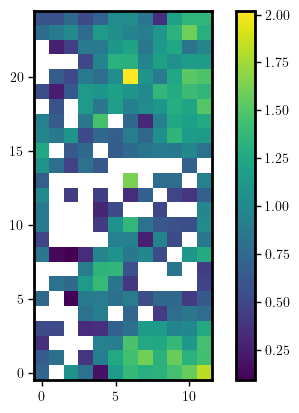

In [19]:
plt.imshow((np.nansum(spicedat_bindown[:,5:30,180:195], axis=0)**(1./2.2)),origin="lower",aspect=1)
plt.colorbar()

In [20]:
spice_err_fac = np.nanstd(spicedat_bindown[:,5:30,180:195])

In [21]:
# spicedat_bindown = spicedat_bindown - np.nanmedian(spicedat_bindown[:,125:175,0:25])

In [22]:
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)

In [73]:
spice_dat1.shape

(192, 145, 50)

In [74]:
NeVIII_deconv_data_rebin_center = deepcopy(NeVIII_770_window_int_map_crop.center)
NeVIII_deconv_data_rebin_scale = u.Quantity((NeVIII_770_window_int_map_crop.scale.axis1,NeVIII_770_window_int_map_crop.scale.axis2*4))
NeVIII_deconv_data_rebin_rmatrix = deepcopy(NeVIII_770_window_int_map_crop.rotation_matrix)
NeVIII_deconv_data_rebin_rmatrix[0,1] = NeVIII_deconv_data_rebin_rmatrix[0,1]*4
NeVIII_deconv_data_rebin_rmatrix[1,0] = NeVIII_deconv_data_rebin_rmatrix[1,0]/4

NeVIII_deconv_data_rebin_header = sunpy.map.make_fitswcs_header(spice_dat1[:,:,0].T.shape,
                                                      NeVIII_deconv_data_rebin_center,
                                                        scale=NeVIII_deconv_data_rebin_scale,
                                                        rotation_matrix=NeVIII_deconv_data_rebin_rmatrix)
NeVIII_deconv_data_rebin_wcs = WCS(NeVIII_deconv_data_rebin_header)


In [23]:
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight,
                                                                    yl_core_xpo=yl_core_xpo,super_fac=1, psf_thold_core=0.0005, spice_bin_facs=rebin_facs,)

Correcting Ne VIII 770 - Peak; ref. wavelength=767.6366184999999
Computing PSF Core:
4.979997240998759 % done after 0.4796895980834961 seconds
9.97378948820527 % done after 0.9311652183532715 seconds
14.96758173541178 % done after 1.3553056716918945 seconds
19.96137398261829 % done after 1.811189889907837 seconds
24.955166229824805 % done after 2.2511911392211914 seconds
29.948958477031315 % done after 2.672556161880493 seconds
34.942750724237825 % done after 3.0955893993377686 seconds
39.93654297144434 % done after 3.5082056522369385 seconds
44.930335218650846 % done after 3.9181089401245117 seconds
49.92412746585736 % done after 4.330325603485107 seconds
54.917919713063874 % done after 4.755766868591309 seconds
59.91171196027038 % done after 5.186837673187256 seconds
64.9055042074769 % done after 5.615196943283081 seconds
69.89929645468341 % done after 6.138659477233887 seconds
74.89308870188992 % done after 6.573879241943359 seconds
79.88688094909642 % done after 7.01096510887146 se

/home/yjzhu/spice_psf/util.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/spice_psf/util.py (40)

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

  @numba.jit(fas

Correcting the PSF:
10.137941360473633 s; Finished slit index 0 of 192 31 of 40 iterations taken, chi^2= 0.0686935675627706
23.576496124267578 s; Finished slit index 1 of 192 32 of 40 iterations taken, chi^2= 0.05888714930983833
33.14300489425659 s; Finished slit index 2 of 192 25 of 40 iterations taken, chi^2= 0.06420299224478677
49.10191488265991 s; Finished slit index 3 of 192 39 of 40 iterations taken, chi^2= 0.04742828202471847
57.5153021812439 s; Finished slit index 4 of 192 23 of 40 iterations taken, chi^2= 0.05156926985477299
68.88615703582764 s; Finished slit index 5 of 192 31 of 40 iterations taken, chi^2= 0.0567547624499275
80.01034998893738 s; Finished slit index 6 of 192 30 of 40 iterations taken, chi^2= 0.053176580996122755
91.18181943893433 s; Finished slit index 7 of 192 32 of 40 iterations taken, chi^2= 0.05328956726519767
104.96218061447144 s; Finished slit index 8 of 192 39 of 40 iterations taken, chi^2= 0.05615754401266242
114.6471951007843 s; Finished slit index 9 

In [24]:
spice_sdev_guess = 0.1
corr_sdev_guess = 0.05


spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_corr_mask, spice_corr_err = get_mask_errs(spice_corr_dat, spice_err_fac)

[det_origin0, det_dims0, det_scale0] = metadict["det_origin0"], metadict["det_dims0"], metadict["det_scale0"]
spice_la = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]

/home/yjzhu/spice_psf/util.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/spice_psf/util.py (40)

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

  @numba.jit(fas

In [25]:
spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

spice_corr_fits = fsl(spice_corr_dat, spice_corr_err, spice_la, spice_corr_mask, spice_wlcen0, corr_sdev_guess)

0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0
0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0


In [26]:
spice_origin_vel = (spice_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_origin_vel = spice_origin_vel - np.nanmedian(spice_origin_vel[:,:])

spice_corr_vel = (spice_corr_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_corr_vel = spice_corr_vel - np.nanmedian(spice_corr_vel[:,:])

Text(0.5, 1.0, 'Corrected')

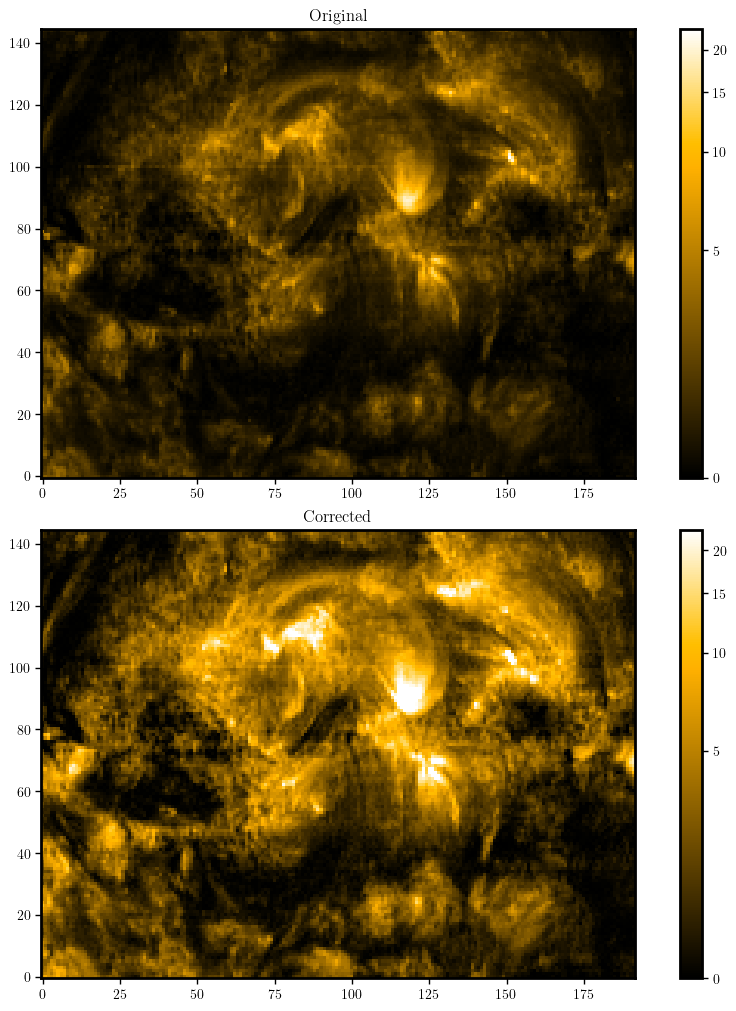

In [27]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

int_norm = ImageNormalize(stretch=AsinhStretch(0.1))

ax1.imshow(spice_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1,
           cmap="sdoaia171")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1,
              cmap="sdoaia171")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")


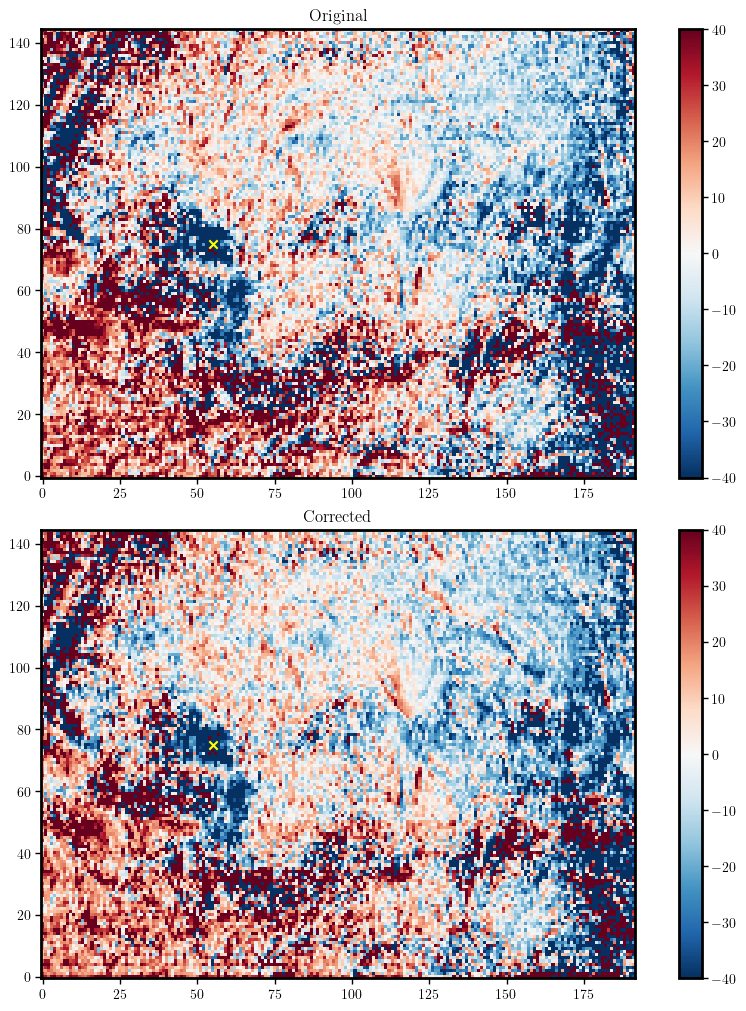

In [39]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

ax1.imshow(spice_origin_vel,origin="lower",vmin=-40,vmax=40,aspect=1,
           cmap="RdBu_r")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_vel,origin="lower",vmin=-40,vmax=40,aspect=1,
                cmap="RdBu_r")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")

for ax_ in (ax1,ax2):
    ax_.scatter(55,75,color="yellow",marker="x")

In [64]:
NeVIII_770_window_wvl = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")
NeVIII_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,16:30].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[16:30],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NeVIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will b

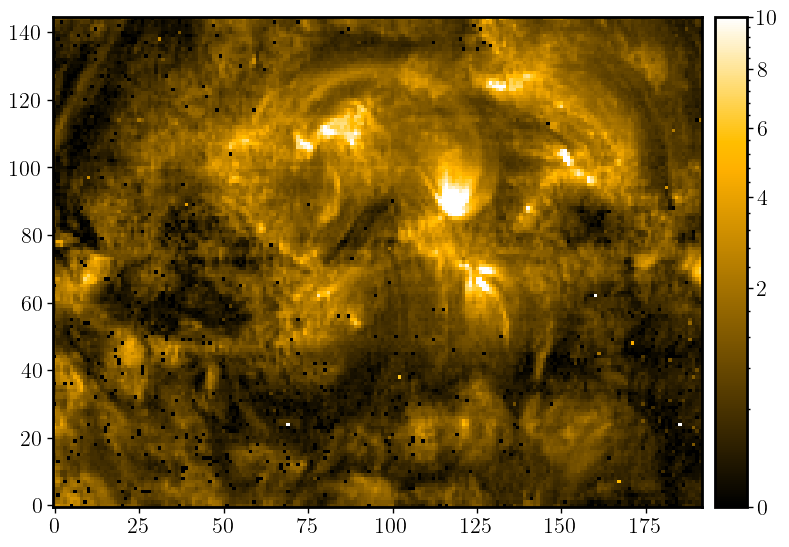

In [66]:
NeVIII_deconv_rebin_int = NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10, scale="sqrt",
                                    aspect=1,cmap="sdoaia171",return_data=True)

Doppler velocity corrected by the median of the image.


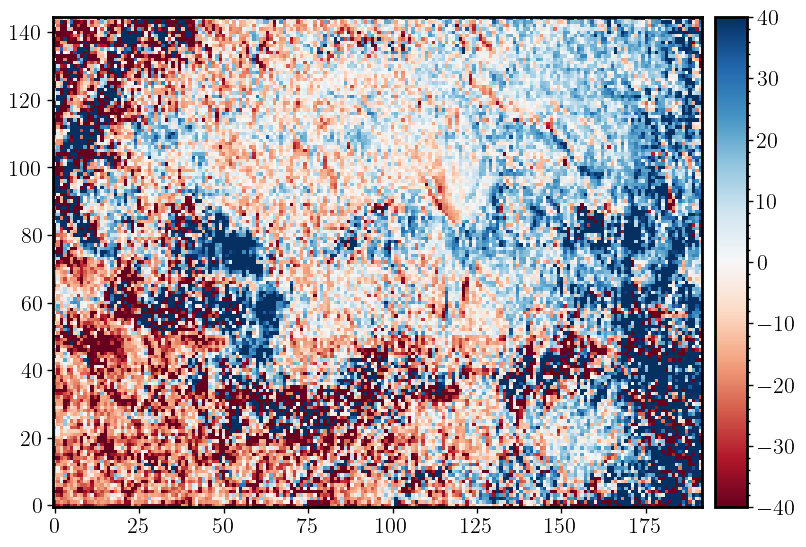

In [67]:
NeVIII_deconv_rebin_vel = NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-40,vmax=40,vel_corr="image",ref_wvl=770.03,   
                                    aspect=1,cmap="RdBu",return_data=True)

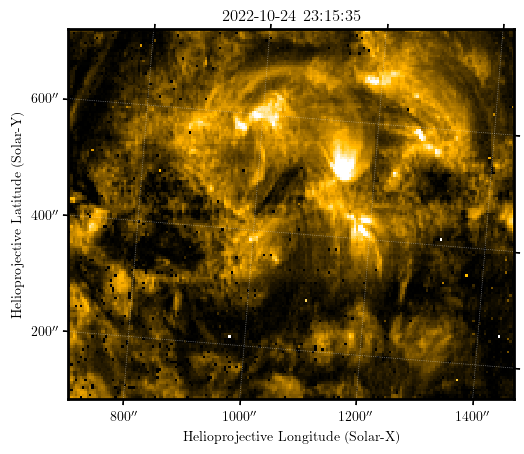

In [86]:
NeVIII_deconv_rebin_int_map = sunpy.map.Map(NeVIII_deconv_rebin_int, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_int_map.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.1))
NeVIII_deconv_rebin_int_map.plot_settings['cmap'] = "sdoaia171"
NeVIII_deconv_rebin_int_map.plot_settings['aspect'] = NeVIII_deconv_rebin_int_map.scale.axis2/NeVIII_deconv_rebin_int_map.scale.axis1
NeVIII_deconv_rebin_int_map.plot()

In [87]:
NeVIII_deconv_rebin_int_map.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_int_map.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_int_map.meta["ycore"], NeVIII_deconv_rebin_int_map.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_int_map.meta["ywing"], NeVIII_deconv_rebin_int_map.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_int_map.meta["wwgt"] = wing_weight
NeVIII_deconv_rebin_int_map.save("../sav/sunpymaps/NeVIII_int_deconv_plowman2023.fits",overwrite=True)

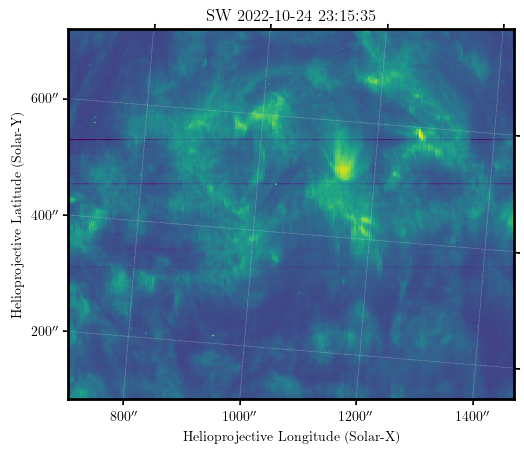

In [76]:
NeVIII_770_window_int_map_crop.plot()

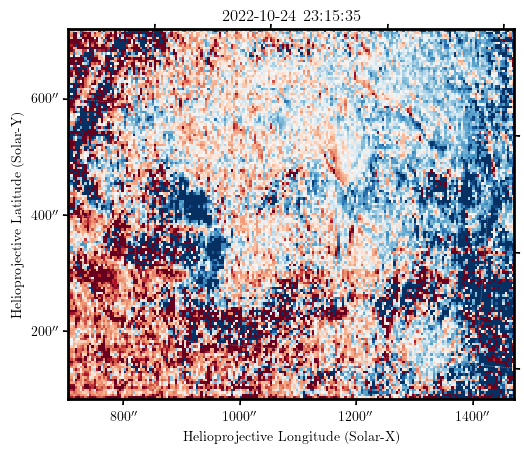

In [89]:
NeVIII_deconv_rebin_vel_map = sunpy.map.Map(-NeVIII_deconv_rebin_vel, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-40,vmax=40)
NeVIII_deconv_rebin_vel_map.plot_settings["cmap"] = "RdBu_r"
NeVIII_deconv_rebin_vel_map.plot_settings["aspect"] = NeVIII_deconv_rebin_vel_map.scale.axis2/NeVIII_deconv_rebin_vel_map.scale.axis1
NeVIII_deconv_rebin_vel_map.plot()

In [90]:
NeVIII_deconv_rebin_vel_map.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_vel_map.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_vel_map.meta["ycore"], NeVIII_deconv_rebin_vel_map.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_vel_map.meta["ywing"], NeVIII_deconv_rebin_vel_map.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_vel_map.meta["wwgt"] = wing_weight
NeVIII_deconv_rebin_vel_map.save("../sav/sunpymaps/NeVIII_vel_deconv_plowman2023.fits",overwrite=True)

In [31]:
spice_corr_dat.shape

(192, 145, 50)

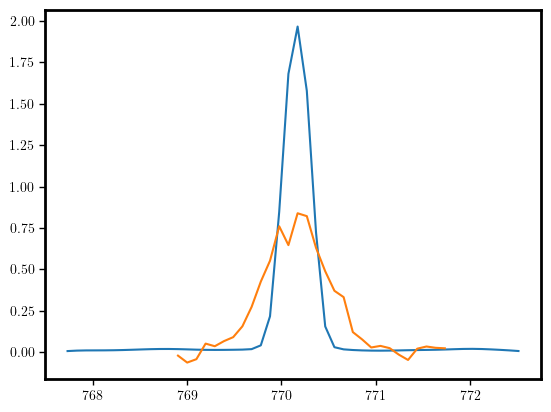

In [32]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[145,50,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[145,50,:])

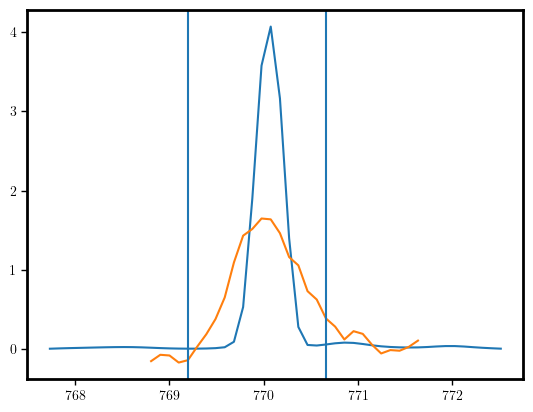

In [33]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[60,62,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[60,62,:])
plt.axvline(NeVIII_770_window_wvl[15])
plt.axvline(NeVIII_770_window_wvl[30])

In [1]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[75,55,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[75,55,:])

NameError: name 'plt' is not defined

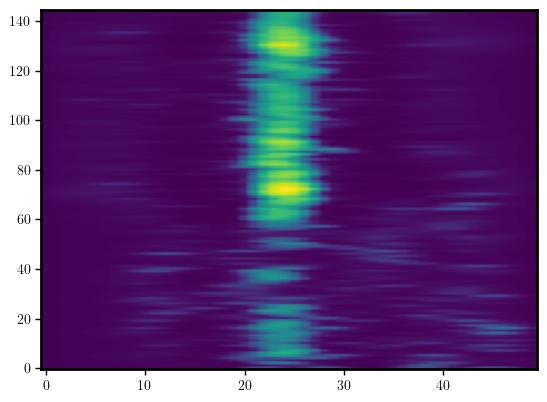

In [35]:
plt.imshow(spice_corr_dat[175,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))

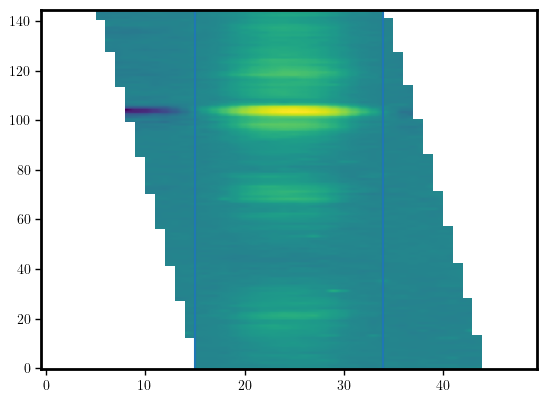

In [36]:
plt.imshow(spice_dat1[151,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))
plt.axvline(15)
plt.axvline(34)

In [37]:
spice_corr_dat.shape

(192, 145, 50)